# AP4 - Pattern Recognition
Implementation of Naive Bayes and Linear Discriminant Analysis(LDA) for classification.

> Name: Jonas Carvalho Fortes

> Mat: 494513

## Load Datasets

In [24]:
import pandas as pd
import numpy as np
from scipy.io import loadmat

dataset_input1 = loadmat('data/Input1.mat')
dataset_input1 = pd.DataFrame(dataset_input1['Input1']).transpose()
print(f'Dataset Input1 shape: {dataset_input1.shape}')

dataset_input2 = loadmat('data/Input2.mat')
dataset_input2 = pd.DataFrame(dataset_input2['Input2']).transpose()
print(f'Dataset Input2 shape: {dataset_input2.shape}')

Dataset Input1 shape: (4000, 2)
Dataset Input2 shape: (4000, 2)


In [25]:
# Create labels for the classes (1 for samples 1-2000, 2 for 2001-4000)
labels = np.array([1]*2000 + [2]*2000)

In [26]:
print('Dataset Input1:')
dataset_input1

Dataset Input1:


,0,1
0,0.545786,1.187656
1,0.369962,1.190989
2,1.713438,-0.191912
3,1.455538,0.378509
4,1.218019,0.646772
...,...,...
3995,0.458675,-1.473266
3996,-0.177021,-1.730604
3997,0.309656,-1.767054
3998,0.913877,-1.752652


In [27]:
print('Dataset Input2:')
dataset_input2

Dataset Input2:


,0,1
0,0.686500,0.494410
1,0.760307,0.609878
2,0.053486,0.811601
3,1.173823,0.359015
4,0.328171,0.907802
...,...,...
3995,0.392458,0.208384
3996,-0.127486,-0.190746
3997,0.057968,-0.320305
3998,1.639673,0.866730


## Helper functions and classes

### Naive Bayes Classifier Modeling

In [47]:
class NaiveBayesClassifier:
    
    def __init__(self):
        # Initialize the mean and variance for each class
        self.mean_class1 = None
        self.var_class1 = None
        self.mean_class2 = None
        self.var_class2 = None
    
    def fit(self, X, y):
        # Separate the samples for each class
        X_class1 = X[y == 1]
        X_class2 = X[y == 2]
        
        # Calculate the mean and variance for each class
        self.mean_class1 = X_class1.mean(axis=0)
        self.var_class1 = X_class1.var(axis=0)
        
        self.mean_class2 = X_class2.mean(axis=0)
        self.var_class2 = X_class2.var(axis=0)
    
    # Calculate the Gaussian probability
    def gaussian_probability(self, x, mean, var):
        exponent = np.exp(- ((x - mean) ** 2) / (2 * var))
        return (1 / np.sqrt(2 * np.pi * var)) * exponent
    
    def predict(self, X):
        predictions = []
        
        for i in range(X.shape[0]):
            sample = X.iloc[i, :]
            # Calculate the probability for Class 1
            prob_class1 = np.prod(self.gaussian_probability(sample, self.mean_class1, self.var_class1))
            # Calculate the probability for Class 2
            prob_class2 = np.prod(self.gaussian_probability(sample, self.mean_class2, self.var_class2))
            
            # Compare the probabilities and assign the class (1 or 2) with the highest probability
            if prob_class1 > prob_class2:
                predictions.append(1)
            else:
                predictions.append(2)
        
        return np.array(predictions)

### LDA Classifier Modeling

In [40]:
class LDAClassifier:
    
    def __init__(self):
        self.w = None  # projection vector (LDA direction)
        self.threshold = None  # decision threshold
    
    def fit(self, X, y):
        # Separate the samples for each class
        X_class1 = X[y == 1]
        X_class2 = X[y == 2]
        
        # Calculate the mean for each class
        mean_class1 = np.mean(X_class1, axis=0)
        mean_class2 = np.mean(X_class2, axis=0)
        
        # Calculate the covariance matrices for each class
        S1 = np.cov(X_class1, rowvar=False)
        S2 = np.cov(X_class2, rowvar=False)
        
        # Calculate the within-class scatter matrix
        Sw = S1 + S2
        
        # Calculate the projection vector w = Sw^(-1) * (mean_class1 - mean_class2)
        self.w = np.linalg.inv(Sw).dot(mean_class1 - mean_class2)
        
        # Project the class means onto the projection vector
        mean1_proj = np.dot(mean_class1, self.w)
        mean2_proj = np.dot(mean_class2, self.w)
        
        # Calculate the decision threshold
        self.threshold = (mean1_proj + mean2_proj) / 2
    
    def predict(self, X):
        # Project the samples onto the projection vector
        X_proj = np.dot(X, self.w)
        
        # Classify the samples based on the projection values and the decision threshold
        predictions = np.where(X_proj > self.threshold, 1, 2)
        return predictions

### Auxiliary Functions

In [41]:
import matplotlib.pyplot as plt

def plot_2d_scatter(X, y):
    """
    Plot a 2D scatter plot of the input data.
    
    Parameters:
    - X: DataFrame or Array-like with the input data (continuous features).
    - y: Array-like with the target labels.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot Classe 1 as blue
    plt.scatter(X[y == 1].iloc[:, 0], X[y == 1].iloc[:, 1], color='blue', label='Classe 1', alpha=0.6)
    
    # Plot Classe 2 as red
    plt.scatter(X[y == 2].iloc[:, 0], X[y == 2].iloc[:, 1], color='red', label='Classe 2', alpha=0.6)
    
    # Configure the plot
    plt.title('Scatter Plot 2D')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

In [42]:
from sklearn.metrics import accuracy_score

def k_fold_cross_validation(X, y, k_folds, model_class):
    """
    Realiza K-fold cross-validation com o classificador especificado
    e retorna as métricas médias de cada fold.

    Args:
        X (np.ndarray): Input data.
        y (np.ndarray): Labels.
        k_folds (int): Numero de folds.
        model_class (class): Classes of the model to be used.(ex: NaiveBayesClassifier, LDAClassifier).

    Returns:
        dict: Dictionary with the average and standard deviation of the accuracy.

    """

    # Split the data into k_folds
    fold_size = len(y) // k_folds
    folds_X = [X[i * fold_size:(i + 1) * fold_size] for i in range(k_folds)]
    folds_y = [y[i * fold_size:(i + 1) * fold_size] for i in range(k_folds)]

    # List to store the accuracies of each fold
    accuracies = []

    # iterate over the folds
    for i in range(k_folds):

        # Separete the data into train and test
        X_test = folds_X[i]
        y_test = folds_y[i]

        # Concatenate the other folds to create the training data
        X_train = np.concatenate([folds_X[j] for j in range(k_folds) if j != i], axis=0)
        y_train = np.concatenate([folds_y[j] for j in range(k_folds) if j != i], axis=0)

        # Create the model
        model = model_class()
        
        # Fit the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate the metrics
        accuracy = accuracy_score(y_test, y_pred)

        # Save the acurracies metrics
        accuracies.append(accuracy)


    # Calculate the mean and standard deviation of the metrics
    mean_accuracy = float(np.mean(accuracies).round(2))
    standard_deviation_accuracy = float(np.std(accuracies).round(2))

    return {
        'accuracy': f'{mean_accuracy * 100}%',
        'accuracy_std': f'{standard_deviation_accuracy * 100}%'
    }


## Evaluation Metrics with K-folds


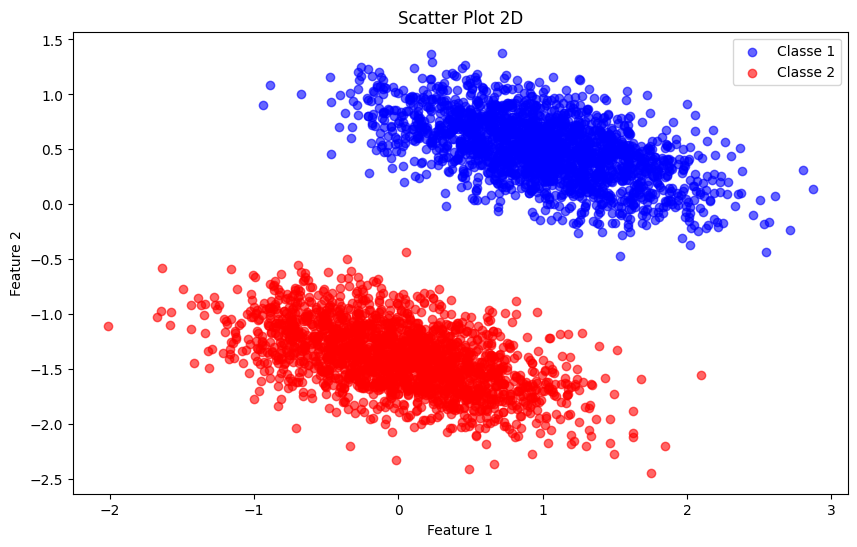

Resultados com Naive Bayes: {'accuracy': '100.0%', 'accuracy_std': '0.0%'}
Resultados com LDA: {'accuracy': '100.0%', 'accuracy_std': '0.0%'}


In [49]:
# Set the data into X and y
X = dataset_input1
y = labels

# Plot the scatter plot 2D for the input data 1
plot_2d_scatter(X, y)

# Use NaiveBayesClassifier with 10-fold cross-validation for the input data 1
naive_bayes_results = k_fold_cross_validation(X, y, k_folds=10, model_class=NaiveBayesClassifier)
print("Resultados com Naive Bayes:", naive_bayes_results)

# Use LDAClassifier with 10-fold cross-validation for the input data 1
lda_results = k_fold_cross_validation(X, y, k_folds=10, model_class=LDAClassifier)
print("Resultados com LDA:", lda_results)

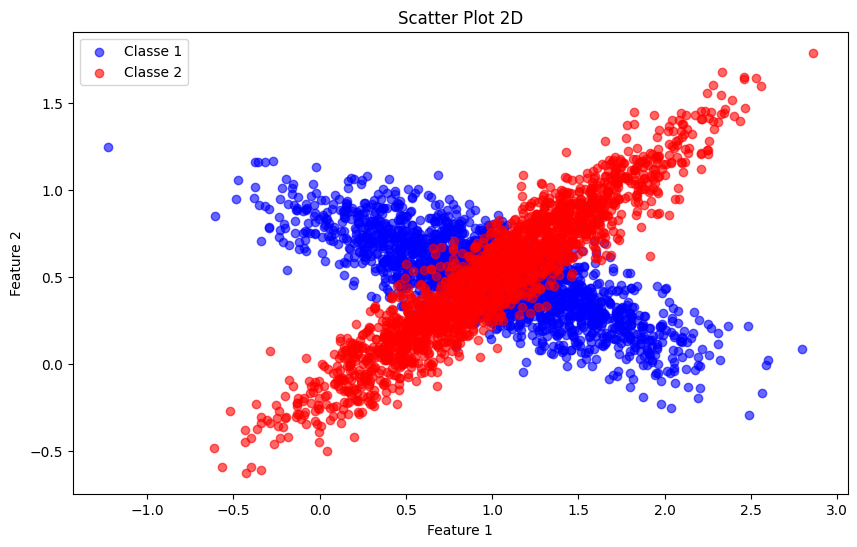

Resultados com Naive Bayes: {'accuracy': '63.0%', 'accuracy_std': '16.0%'}
Resultados com LDA: {'accuracy': '50.0%', 'accuracy_std': '3.0%'}


In [50]:
# Set the data into X and y
X = dataset_input2
y = labels

# Plot the scatter plot 2D for the input data 2
plot_2d_scatter(X, y)

# Use NaiveBayesClassifier with 10-fold cross-validation for the input data 2
naive_bayes_results = k_fold_cross_validation(X, y, k_folds=10, model_class=NaiveBayesClassifier)
print("Resultados com Naive Bayes:", naive_bayes_results)

# Use LDAClassifier with 10-fold cross-validation for the input data 2
lda_results = k_fold_cross_validation(X, y, k_folds=10, model_class=LDAClassifier)
print("Resultados com LDA:", lda_results)